# Splitting Data and having Dataset and Dataloader

Note: to run this notebook, follow the link: https://www.kaggle.com/code/gesakluka/ml-project-model-training

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
from tqdm import trange


In [2]:
use_cuda = False
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


In [3]:
df = pd.read_csv('/kaggle/input/cleaned-df-gesa-csv/airbnb_cleaned_final.csv')

In [4]:
#df = df.fillna(0) # just fill the last stuff with 0 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           9815 non-null   int64  
 1   host_id                      9815 non-null   int64  
 2   host_since                   9815 non-null   int64  
 3   host_total_listings_count    9815 non-null   int64  
 4   neighbourhood_cleansed       9815 non-null   int64  
 5   latitude                     9815 non-null   float64
 6   longitude                    9815 non-null   float64
 7   room_type                    9815 non-null   int64  
 8   accommodates                 9815 non-null   int64  
 9   bedrooms                     9815 non-null   float64
 10  beds                         9815 non-null   float64
 11  price                        9815 non-null   float64
 12  minimum_nights               9815 non-null   int64  
 13  maximum_nights    

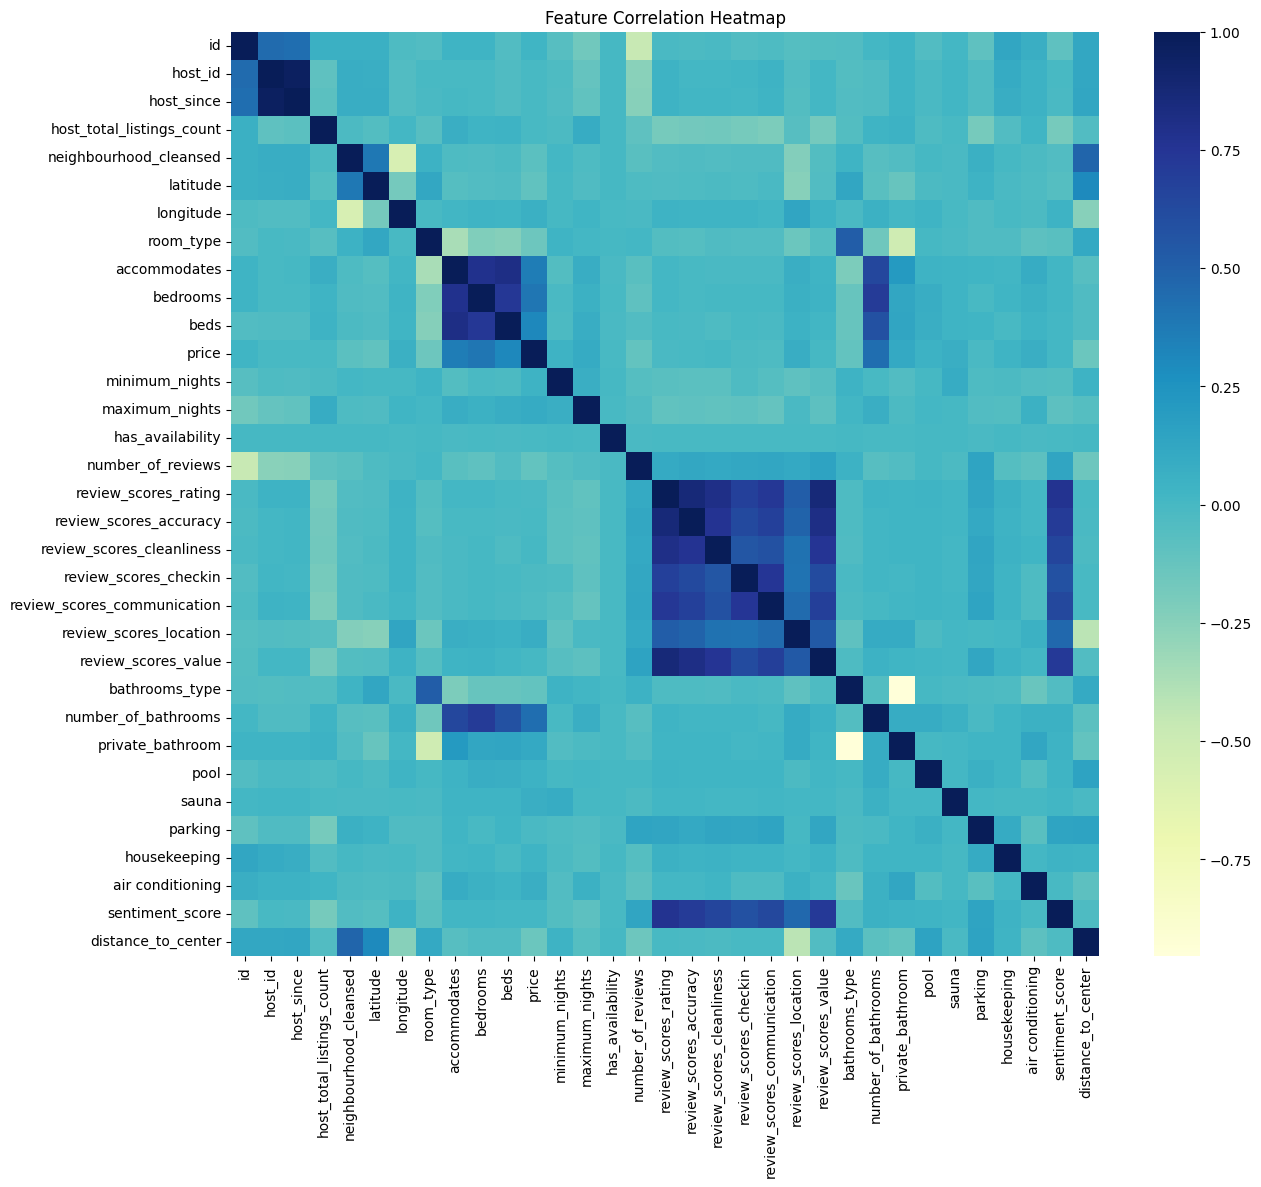

In [5]:
X = df.drop(columns='price')
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), cmap='YlGnBu')
plt.title("Feature Correlation Heatmap");

# If we need to use pytorch

## Dataset

In [6]:
class AirbnbDataset(Dataset):
    def __init__(self, df, target_clm, normalise=True, mean=None, std=None):
        self.X = df.drop(columns=target_clm).values
        self.y = df.loc[:,target_clm].values
        #self.y = np.log1p(self.y) # do min max normalization
        self.mean = mean
        self.std = std
        self.normalise = normalise

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        data = self.X[index]
        if self.normalise and self.mean is not None and self.std is not None:
            std_adj = np.where(self.std == 0, 1, self.std)
            data = (data - self.mean) / std_adj
        return data, self.y[index]

In [7]:
batch_size = 32

## Dataloader

# Helper funktions

In [8]:
train_data, test_data = train_test_split(df.drop(columns='id'), test_size=0.1, random_state=42)
train_subset, val_subset = train_test_split(train_data, test_size=0.2, random_state=42)
# Compute mean and std for normalization
mean = np.mean(train_subset.drop(columns=['price']), axis=0).values
std = np.std(train_subset.drop(columns=['price']), axis=0).values

# Wrap raw tensors into custom dataset
train_dataset = AirbnbDataset(train_subset, 'price', normalise=True, mean=mean, std=std)
val_dataset = AirbnbDataset(val_subset, 'price', normalise=True, mean=mean, std=std)
test_dataset = AirbnbDataset(test_data, 'price', normalise=True, mean=mean, std=std)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # dont shuffle test_loader 

### Train, Validation, Running and getting Predictions

In [9]:
def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """

    lossTrain = []                                                          # Loss for each batch
    model = model.to(device).train()                                        # Move to device and set traing mode
    truValue = []
    predValue = []

    for xBatch, yBatch in dataloader:
        xBatch = xBatch.to(device=device, dtype=torch.float32)              # Move batch to device and set type
        yBatch = yBatch.to(device=device, dtype=torch.float32)              # Move batch to device and set type
        yBatch = yBatch.view(-1, 1)



        optimizer.zero_grad()                                               # Clear previous gradients
        yPred = model(xBatch) 
        # Forward pass: calc prediction
        loss = loss_fn(yPred, yBatch)                                       # Calc loss
        loss.backward()                                                     # Backpropagation: calc gradients
        optimizer.step()                                                    # Update model parameters
        lossTrain.append(loss.item())                                       # Safe loss
        truValue.append(yBatch.cpu().detach().numpy())                          # Store true values as numpy arrays
        predValue.append(yPred.cpu().detach().numpy()) 




    return np.mean(lossTrain), truValue, predValue                                               # Return mean loss



def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """

    lossVal = []                                                            # Loss for each batch
    model = model.to(device).eval()                                         # Move to device and set eval mode
    truValue = []
    predValue = []

    with torch.no_grad():                                                   # Disable gradient calc
        for xBatch, yBatch in dataloader:
            xBatch = xBatch.to(device=device, dtype=torch.float32)          # Move batch to device and set type
            yBatch = yBatch.to(device=device, dtype=torch.float32)             # Move batch to device and set type
            yBatch = yBatch.view(-1, 1)
            yPred = model(xBatch)                                           # Forward pass: calc prediction
            loss = loss_fn(yPred, yBatch)                                   # Calc loss 
            lossVal.append(loss.item())                                     # Safe loss
            truValue.append(yBatch.cpu().detach().numpy())                          # Store true values as numpy arrays
            predValue.append(yPred.cpu().detach().numpy())                          # Store predicted values as numpy arrays
    return np.mean(lossVal), truValue, predValue                                                  # Return mean loss and accuracy





def runTraining(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, N, tol,scheduler):
    """ method to run the training procedure """

    epochBar = tqdm(range(num_epochs), desc="Training Epochs")
    trainLosses = []
    valLosses = []
    truValueTrain = []
    predValueTrain = []
    truValueVal = []
    predValueVal = []
    minLosses=np.inf
    counter=0
    for i,epoch in enumerate(epochBar):
        
        
        trainLossesEpoch, truValueEpoch, predValueEpoch = train(train_dataloader, optimizer, model, loss_function, device)
        trainLosses.append(trainLossesEpoch)
        truValueTrain.append(truValueEpoch)
        predValueTrain.append(predValueEpoch)

        
        valLossesEpoch, truValueEpoch, predValueEpoch  = validate(val_dataloader, model, loss_function, device)
        valLosses.append(valLossesEpoch)
        truValueVal.append(truValueEpoch)
        predValueVal.append(predValueEpoch)
        epochBar.set_postfix({'Training loss': f'{trainLossesEpoch:.4f}','Validation loss': f'{valLossesEpoch:.4f}',})
        if N!=None and tol!=None:
            if minLosses-valLosses[i]<tol:
                counter+=1
                if counter==N:
                    print("stopped in Epoch: ",i)
                    break
            else:
                counter=0
                minLosses=valLosses[i]
        if scheduler!=None:
            scheduler.step()

    return trainLosses, valLosses, truValueTrain, predValueTrain, truValueVal, predValueVal

## Plot functions

In [10]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, marker='o', label='Train Losses', color='deeppink')
    plt.plot(val_losses, marker='o', label='Validation Losses', color='hotpink')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend();

In [11]:
def true_vs_predicted(valLosses, trueValueVal, predValueVal, labelModel):
    epoch = valLosses.index(min(valLosses))
    x1 = np.concatenate(trueValueVal[epoch], axis=0)
    y1 = np.concatenate(predValueVal[epoch], axis=0)
    
    mae = mean_absolute_error(x1, y1)
    r2 = r2_score(x1, y1)
    print("Mean absolute error: ",mae)
    print('R2-Score: ', r2)
    print("Epoch: ",epoch)
    print("Losses of the epoch: ",valLosses[epoch])

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))
    ax1.set_title("Scatter Plot: True vs Predicted")
    ax1.scatter(x1, y1, color="deeppink", alpha=0.5, label=labelModel)
    ax1.plot([0, max(x1.max(),y1.max())], [0, max(x1.max(),y1.max())], color='black', linestyle='--', label='Perfect Prediction')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.legend()
    ax2.set_title("Scatter Plot: True vs Predicted in the lower price range")
    ax2.scatter(x1, y1, color="deeppink", alpha=0.5, label=labelModel)
    ax2.plot([0, 500], [0, 500], color='black', linestyle='--', label='Perfect Prediction')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Predicted Values")
    ax2.set_xlim([0, 500])
    ax2.set_ylim([0, 500])
    ax2.legend()
    plt.show()

# Linear Regression using Pytorch

In [12]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
            super(LinearRegression, self).__init__()
            self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

In [13]:
element = next(iter(train_loader))
X, y = element
print(X.shape, y.shape)

torch.Size([32, 31]) torch.Size([32])


In [14]:
# Model parameters and hyperparameters
learning_rate = 0.008
num_epochs = 200

In [15]:
lg_model = LinearRegression(X.shape[1], 1).to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(lg_model.parameters(), lr=learning_rate, weight_decay=0.0005)

In [16]:
lg_trainLosses, lg_valLosses, lg_truValueTrain, lg_predValueTrain, lg_trueValueVal, lg_predValueVal = runTraining(
    lg_model, optimizer, loss_fn, device, num_epochs, train_loader, val_loader, 10, 0.1, None)

Training Epochs:  96%|█████████▌| 191/200 [00:53<00:02,  3.57it/s, Training loss=65.0787, Validation loss=60.6474]

stopped in Epoch:  191


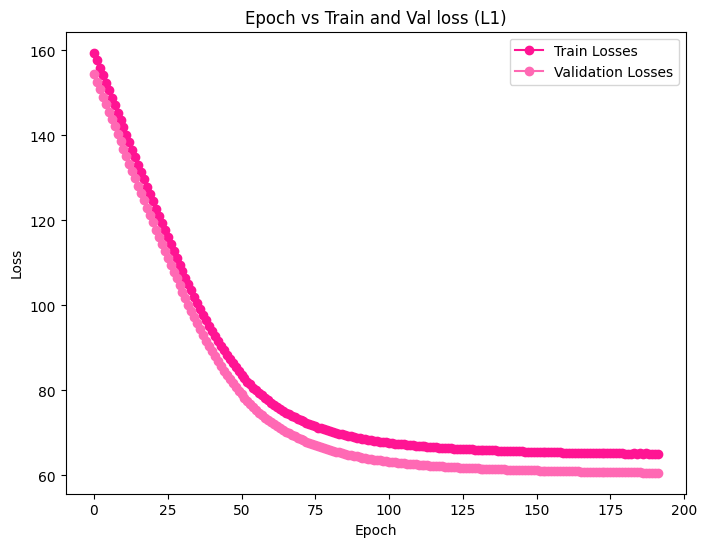

In [17]:
plot_losses(lg_trainLosses, lg_valLosses, 'Epoch vs Train and Val loss (L1)')

Mean absolute error:  61.238995
R2-Score:  0.1826166275632891
Epoch:  191
Losses of the epoch:  60.647431407655986


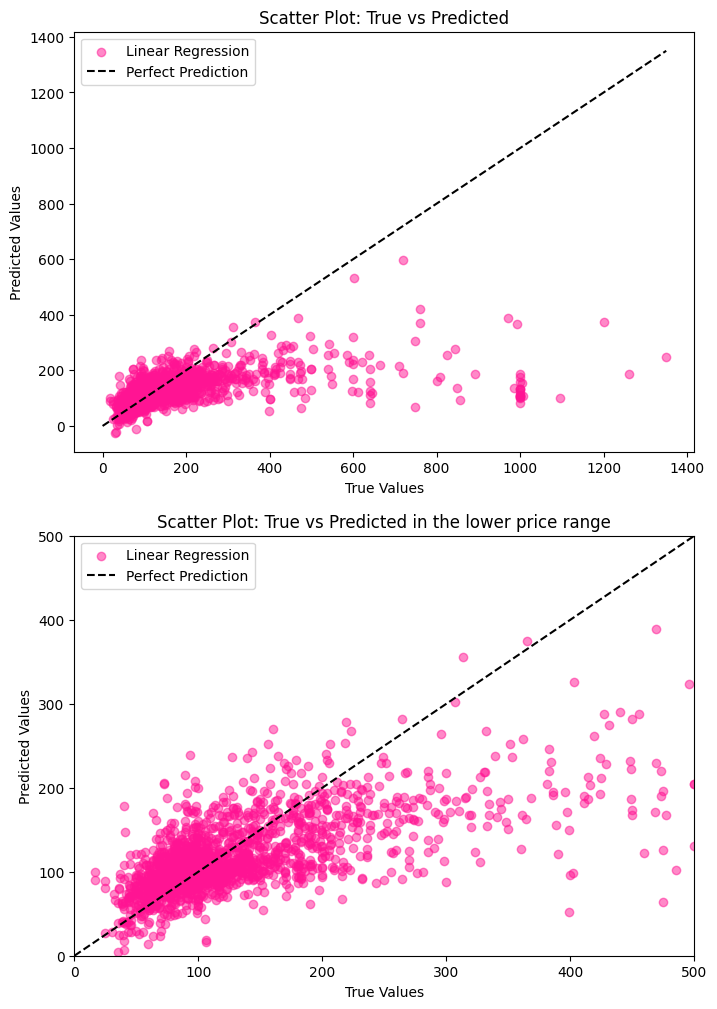

In [18]:
true_vs_predicted(lg_valLosses, lg_trueValueVal, lg_predValueVal, 'Linear Regression')

## Insight of the day:  'Ja, Linear Regression ist nicht der Weg'

# Multi Layer Perceptron

In [19]:
class MLP1(nn.Module):
    def __init__(self, input_dim):
        super(MLP1, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),   # Input layer, hidden layer (128 neurons)
            nn.ReLU(),                   # Activation function
            nn.Linear(128, 64),          # another hidden layer (64 neurons)
            nn.ReLU(),                   
            nn.Linear(64, 32),           # another hidden layer (32 neurons)
            nn.ReLU(),
            nn.Linear(32, 1)             # Final layer → output a single number (price)
        )

    def forward(self, x):
        return self.model(x)

In [20]:
MLP1_model = MLP1(X.shape[1]).to(device)
optimizer = torch.optim.Adam(MLP1_model.parameters(), lr=0.001, weight_decay=0.00005)
loss_fn = torch.nn.HuberLoss(delta=2)
MLP1_trainLosses, MLP1_valLosses, MLP1_truValueTrain, MLP1_predValueTrain, MLP1_trueValueVal, MLP1_predValueVal = runTraining(
    MLP1_model, optimizer, loss_fn, device, num_epochs, train_loader, val_loader, 10, 0.1, None)

Training Epochs:  22%|██▏       | 43/200 [00:23<01:25,  1.84it/s, Training loss=108.2417, Validation loss=110.5189]

stopped in Epoch:  43


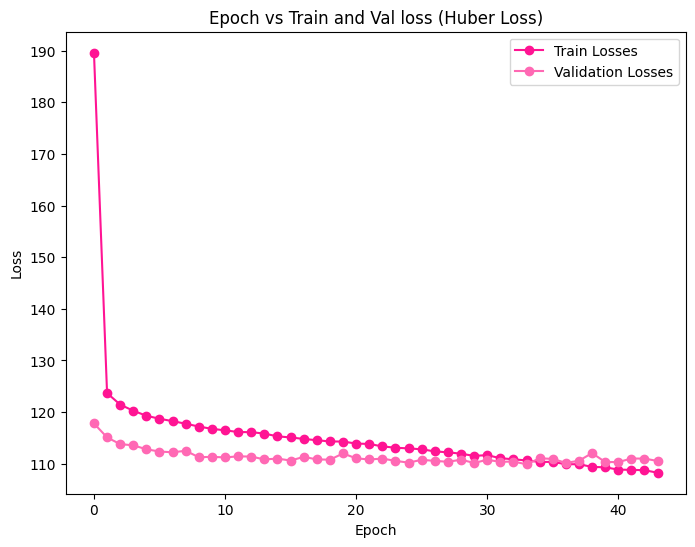

In [21]:
plot_losses(MLP1_trainLosses, MLP1_valLosses, 'Epoch vs Train and Val loss (Huber Loss)')

Mean absolute error:  56.453106
R2-Score:  0.28160724734507736
Epoch:  33
Losses of the epoch:  109.87771327154977


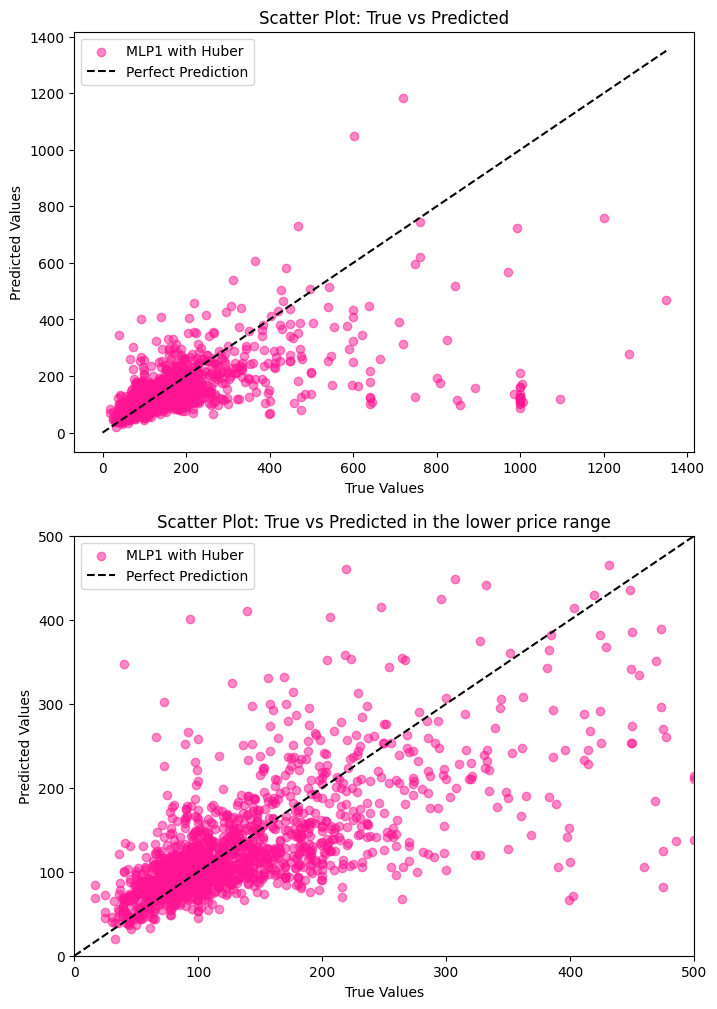

In [22]:
true_vs_predicted(MLP1_valLosses, MLP1_trueValueVal, MLP1_predValueVal, 'MLP1 with Huber')

In [23]:
class MLP2(nn.Module):
    def __init__(self, input_dim):
        super(MLP2, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),   # Input layer, hidden layer (128 neurons)
            nn.ReLU(),                   # Activation function
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),          # another hidden layer (64 neurons)
            nn.ReLU(),                   
            nn.Linear(64, 32),           # another hidden layer (32 neurons)
            nn.ReLU(),
            nn.Linear(32, 1)             # Final layer → output a single number (price)
        )

    def forward(self, x):
        return self.model(x)

In [24]:
MLP2_model = MLP2(X.shape[1]).to(device)
optimizer = torch.optim.Adam(MLP2_model.parameters(), lr=0.001, weight_decay=0.0005)
loss_fn = torch.nn.HuberLoss()

MLP2_trainLosses, MLP2_valLosses, MLP2_truValueTrain, MLP2_predValueTrain, MLP2_trueValueVal, MLP2_predValueVal = runTraining(
    MLP2_model, optimizer, loss_fn, device, num_epochs, train_loader, val_loader, 10, 0.1, None)

Training Epochs:  14%|█▍        | 29/200 [00:27<02:41,  1.06it/s, Training loss=53.4593, Validation loss=56.4484]

stopped in Epoch:  29


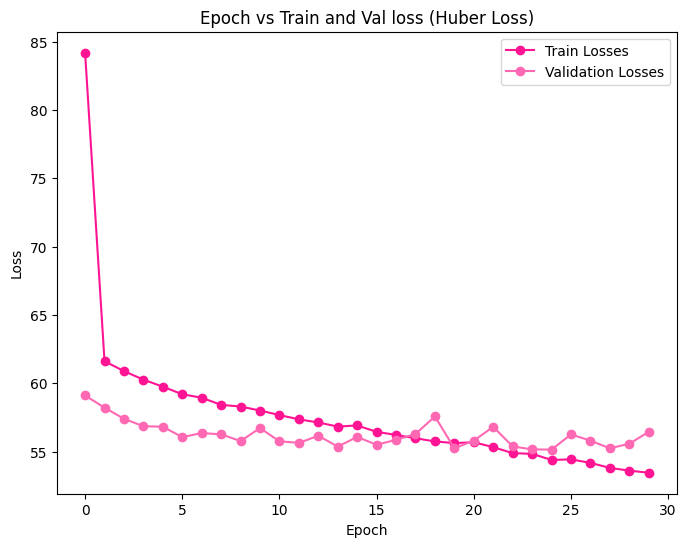

In [25]:
plot_losses(MLP2_trainLosses, MLP2_valLosses, 'Epoch vs Train and Val loss (Huber Loss)')

Mean absolute error:  56.14915
R2-Score:  0.2785874654974837
Epoch:  24
Losses of the epoch:  55.14760667937143


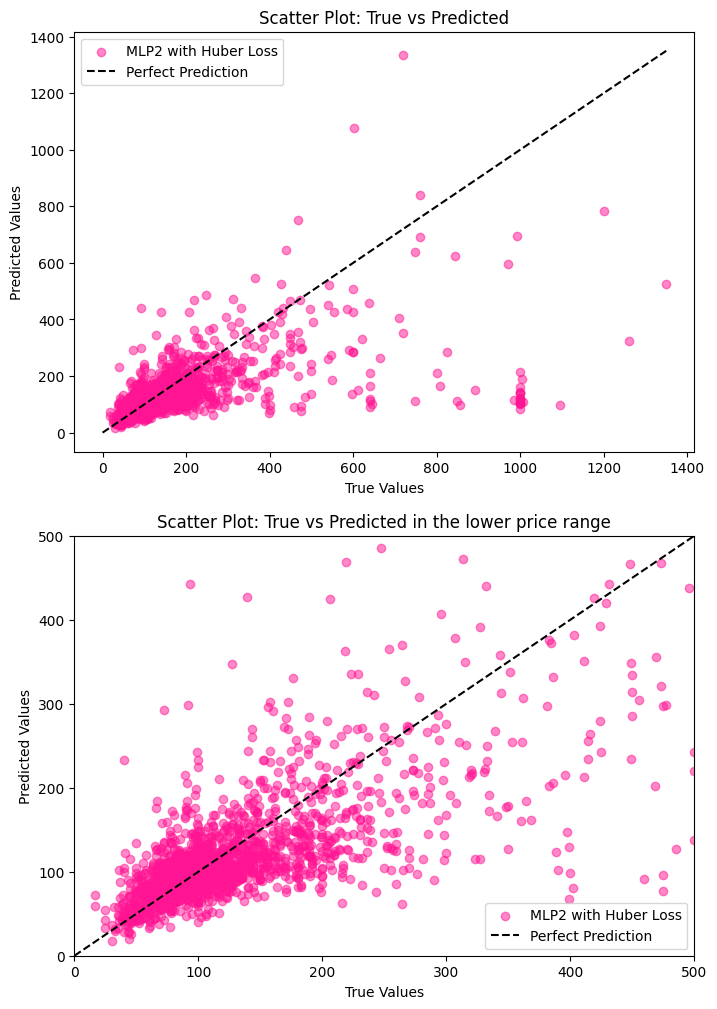

In [26]:
true_vs_predicted(MLP2_valLosses, MLP2_trueValueVal, MLP2_predValueVal, 'MLP2 with Huber Loss')

In [27]:
class MLP3(nn.Module):
    def __init__(self, input_dim):
        super(MLP3, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),   # Input layer, hidden layer (128 neurons)
            nn.ReLU(),                   # Activation function
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),          # another hidden layer (64 neurons)
            nn.ReLU(),                   
            nn.Linear(64, 32),           # another hidden layer (32 neurons)
            nn.ReLU(),
            nn.Linear(32, 16),            
            nn.ReLU(),
            nn.Linear(16, 1),# Final layer → output a single number (price)
        )

    def forward(self, x):
        return self.model(x)

In [28]:
MLP3_model = MLP3(X.shape[1]).to(device)
optimizer = torch.optim.Adam(MLP3_model.parameters(), lr=0.001, weight_decay = 0.005)
loss_fn = torch.nn.L1Loss()

MLP3_trainLosses, MLP3_valLosses, MLP3_truValueTrain, MLP3_predValueTrain, MLP3_trueValueVal, MLP3_predValueVal = runTraining(
    MLP3_model, optimizer, loss_fn, device, num_epochs, train_loader, val_loader, 10, 0.1, None)

Training Epochs:  24%|██▍       | 48/200 [00:43<02:18,  1.10it/s, Training loss=51.3996, Validation loss=56.8833]

stopped in Epoch:  48


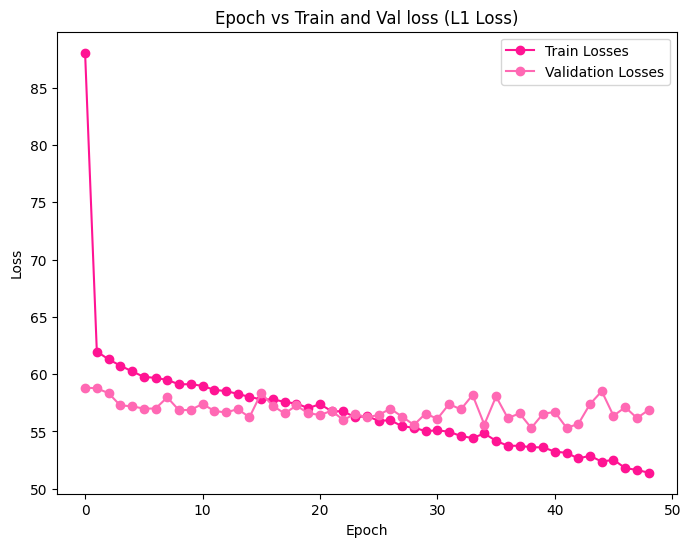

In [29]:
plot_losses(MLP3_trainLosses, MLP3_valLosses, 'Epoch vs Train and Val loss (L1 Loss)')

Mean absolute error:  55.881287
R2-Score:  0.2926052072641586
Epoch:  38
Losses of the epoch:  55.304872325488496


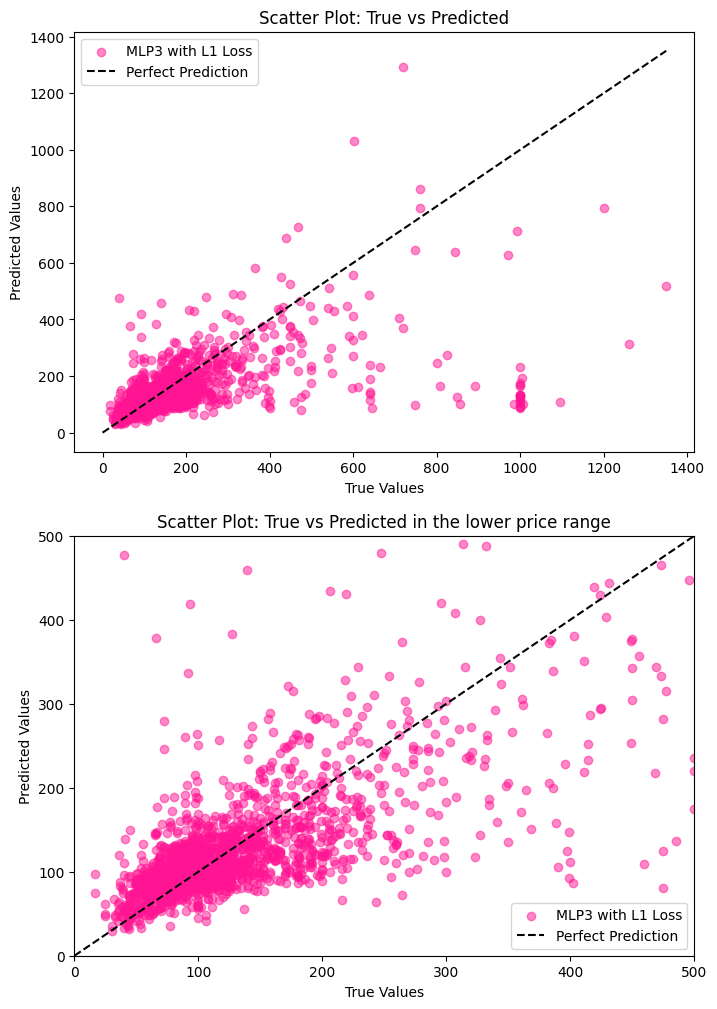

In [30]:
true_vs_predicted(MLP3_valLosses, MLP3_trueValueVal, MLP3_predValueVal, 'MLP3 with L1 Loss')